## 1. Setup and Imports

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import time

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Standard libraries loaded")

✓ Standard libraries loaded


In [2]:
# Add parent directory to path for imports
import sys
sys.path.insert(0, '../')

# Import project modules
from src.data_loader import load_wine_quality, preprocess_data, split_data
from src.feature_analysis import FeatureAnalyzer
from src.ensemble import ScalingEnsemble

print("✓ Project modules loaded")

✓ Project modules loaded


In [3]:
# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from scipy import stats as scipy_stats

print("✓ Scikit-learn modules loaded")

✓ Scikit-learn modules loaded


In [4]:
# Create results directories
RESULTS_DIR = Path('../results/adaptive_scaling')
FIGURES_DIR = RESULTS_DIR / 'figures'

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"✓ Results directory: {RESULTS_DIR}")
print(f"✓ Figures directory: {FIGURES_DIR}")

✓ Results directory: ../results/adaptive_scaling
✓ Figures directory: ../results/adaptive_scaling/figures


In [5]:
# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"✓ Random seed set to {RANDOM_STATE}")

✓ Random seed set to 42


## 2. Load Wine Quality Dataset

In [6]:
# Load the wine quality dataset
print("Loading Wine Quality dataset...")
X, y = load_wine_quality()
feature_names = X.columns.tolist()

print(f"\n✓ Dataset loaded successfully!")
print(f"  Samples: {X.shape[0]}")
print(f"  Features: {X.shape[1]}")
print(f"  Feature names: {feature_names}")

Loading Wine Quality dataset...
Wine Quality Dataset loaded: 6497 samples, 12 features
Class distribution: {0: 5220, 1: 1277}

✓ Dataset loaded successfully!
  Samples: 6497
  Features: 12
  Feature names: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'wine_type']


In [7]:
# Preprocess data
X_processed, y_processed = preprocess_data(X, y)

print(f"Class distribution:")
unique, counts = np.unique(y_processed, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} ({count/len(y_processed)*100:.1f}%)")

Class distribution:
  Class 0: 5220 (80.3%)
  Class 1: 1277 (19.7%)


In [8]:
# Split into train/test sets (same split as other notebooks)
X_train, X_test, y_train, y_test = split_data(
    X, y_processed, 
    test_size=0.2, 
    random_state=RANDOM_STATE
)

print(f"\n✓ Data split complete:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")


Data split: 5197 train, 1300 test samples
Train class distribution: {0: 4176, 1: 1021}
Test class distribution: {0: 1044, 1: 256}

✓ Data split complete:
  Training samples: 5197
  Test samples: 1300


## 3. Analyze Feature Distributions

### 3.1 Compute Feature Statistics

In [9]:
# Analyze feature distributions
analyzer = FeatureAnalyzer(
    X=pd.DataFrame(X_train, columns=feature_names),
    y=pd.Series(y_train),
    dataset_name="Wine_Quality_Adaptive"
)

# Compute all statistics
stats = analyzer.compute_all_statistics(iqr_multiplier=1.5)

print("✓ Feature statistics computed")


Feature Analysis: Wine_Quality_Adaptive
Samples: 5197, Features: 12

Summary Statistics:
  Total outliers: 2870
  Avg outlier %: 4.60%
  Max outlier %: 24.98%
  Range ratio (max/min): 8367.07
  Std ratio (max/min): 18707.68
  Avg |skewness|: 1.39
  Max |kurtosis|: 52.65
  Class balance: {0: 4176, 1: 1021}
✓ Feature statistics computed


In [10]:
# Display feature statistics
dist_stats = stats['distribution']
outlier_stats = stats['outliers']

# Combine relevant statistics
feature_analysis = pd.DataFrame({
    'feature': dist_stats['feature'],
    'mean': dist_stats['mean'],
    'std': dist_stats['std'],
    'skewness': dist_stats['skewness'],
    'kurtosis': dist_stats['kurtosis'],
    'range': dist_stats['range'],
    'outlier_pct': outlier_stats['outlier_percentage']
})

print("\nFeature Analysis:")
print("="*80)
display(feature_analysis.round(3))
print("="*80)


Feature Analysis:


,feature,mean,std,skewness,kurtosis,range,outlier_pct
0,fixed acidity,7.219,1.300,1.701,4.936,11.700,5.619
1,volatile acidity,0.341,0.166,1.522,3.004,1.500,6.003
2,citric acid,0.320,0.145,0.361,1.388,1.230,6.985
3,residual sugar,5.410,4.746,1.523,5.453,65.100,1.751
4,chlorides,0.056,0.036,5.548,52.655,0.602,4.349
5,free sulfur dioxide,30.435,17.925,1.352,9.454,288.000,1.020
6,total sulfur dioxide,115.347,56.560,0.009,-0.350,434.000,0.173
7,density,0.995,0.003,0.638,8.142,0.052,0.058
8,pH,3.219,0.161,0.394,0.468,1.290,1.231
9,sulphates,0.533,0.152,1.896,9.518,1.750,3.021


### 3.2 Define Scaler Selection Rules

Based on feature characteristics:
- **RobustScaler**: High outlier percentage (>10%)
- **StandardScaler**: Normal-like distribution (|skewness| < 1, low outliers)
- **MinMaxScaler**: Bounded range, low skewness
- **MaxAbsScaler**: Sparse features or when preserving zero is important

In [11]:
def select_scaler_for_feature(row):
    """
    Select the best scaler for a feature based on its characteristics.
    
    Rules:
    1. If outlier_pct > 15%: RobustScaler (resistant to outliers)
    2. Elif |skewness| > 2: RobustScaler (handles heavy tails)
    3. Elif outlier_pct > 5% and |skewness| > 1: RobustScaler
    4. Elif |skewness| < 0.5: StandardScaler (approximately normal)
    5. Else: MinMaxScaler (for bounded, moderate skew)
    """
    outlier_pct = row['outlier_pct']
    skewness = abs(row['skewness'])
    
    if outlier_pct > 15:
        return 'RobustScaler', 'High outliers'
    elif skewness > 2:
        return 'RobustScaler', 'Heavy skew'
    elif outlier_pct > 5 and skewness > 1:
        return 'RobustScaler', 'Outliers + skew'
    elif skewness < 0.5:
        return 'StandardScaler', 'Approx normal'
    else:
        return 'MinMaxScaler', 'Moderate skew'

# Apply scaler selection
feature_analysis[['selected_scaler', 'reason']] = feature_analysis.apply(
    select_scaler_for_feature, axis=1, result_type='expand'
)

print("\nAdaptive Scaler Selection:")
print("="*80)
display(feature_analysis[['feature', 'skewness', 'outlier_pct', 'selected_scaler', 'reason']])
print("="*80)


Adaptive Scaler Selection:


,feature,skewness,outlier_pct,selected_scaler,reason
0,fixed acidity,1.701166,5.618626,RobustScaler,Outliers + skew
1,volatile acidity,1.521892,6.003464,RobustScaler,Outliers + skew
2,citric acid,0.361075,6.984799,StandardScaler,Approx normal
3,residual sugar,1.523158,1.751010,MinMaxScaler,Moderate skew
4,chlorides,5.548253,4.348663,RobustScaler,Heavy skew
5,free sulfur dioxide,1.352424,1.019819,MinMaxScaler,Moderate skew
6,total sulfur dioxide,0.009490,0.173177,StandardScaler,Approx normal
7,density,0.638089,0.057726,MinMaxScaler,Moderate skew
8,pH,0.393591,1.231480,StandardScaler,Approx normal
9,sulphates,1.895632,3.020974,MinMaxScaler,Moderate skew



Scaler Distribution:
  MinMaxScaler   : 5 features (41.7%)
  RobustScaler   : 4 features (33.3%)
  StandardScaler : 3 features (25.0%)


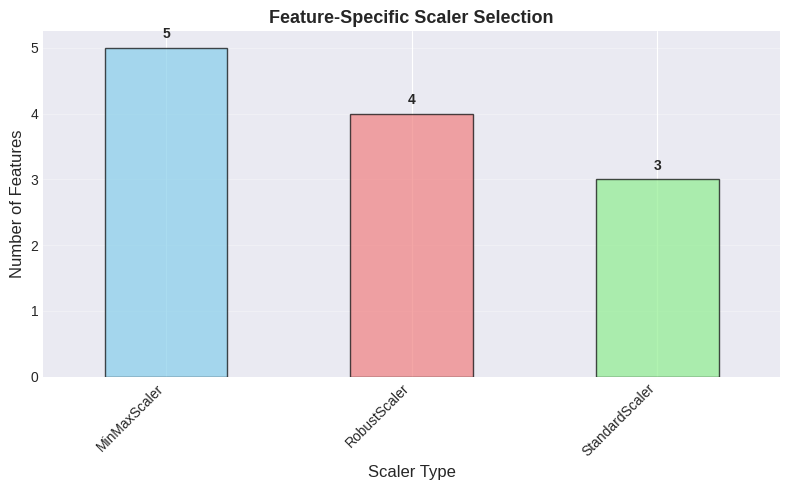


✓ Scaler distribution saved to ../results/adaptive_scaling/figures/scaler_distribution.png


In [12]:
# Summary of scaler distribution
scaler_counts = feature_analysis['selected_scaler'].value_counts()

print("\nScaler Distribution:")
for scaler, count in scaler_counts.items():
    print(f"  {scaler:15s}: {count} features ({count/len(feature_analysis)*100:.1f}%)")

# Visualize scaler distribution
fig, ax = plt.subplots(figsize=(8, 5))
scaler_counts.plot(kind='bar', ax=ax, color=['skyblue', 'lightcoral', 'lightgreen'], alpha=0.7, edgecolor='black')
ax.set_xlabel('Scaler Type', fontsize=12)
ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Feature-Specific Scaler Selection', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, v in enumerate(scaler_counts.values):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
save_path = FIGURES_DIR / 'scaler_distribution.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Scaler distribution saved to {save_path}")

## 4. Build Adaptive Scaling Pipeline

### 4.1 Create Feature Groups by Scaler

In [13]:
# Group features by selected scaler
scaler_groups = {}
for scaler_name in feature_analysis['selected_scaler'].unique():
    features = feature_analysis[feature_analysis['selected_scaler'] == scaler_name]['feature'].tolist()
    scaler_groups[scaler_name] = features

print("Feature Groups by Scaler:")
print("="*80)
for scaler_name, features in scaler_groups.items():
    print(f"\n{scaler_name}:")
    for feat in features:
        print(f"  - {feat}")
print("="*80)

Feature Groups by Scaler:

RobustScaler:
  - fixed acidity
  - volatile acidity
  - chlorides
  - wine_type

StandardScaler:
  - citric acid
  - total sulfur dioxide
  - pH

MinMaxScaler:
  - residual sugar
  - free sulfur dioxide
  - density
  - sulphates
  - alcohol


### 4.2 Create ColumnTransformer with Feature-Specific Scalers

In [14]:
# Map scaler names to scaler objects
scaler_map = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'MaxAbsScaler': MaxAbsScaler()
}

# Create transformers list for ColumnTransformer
transformers = []
for scaler_name, features in scaler_groups.items():
    # Get feature indices
    feature_indices = [feature_names.index(f) for f in features]
    transformers.append((scaler_name, scaler_map[scaler_name], feature_indices))

# Create ColumnTransformer
adaptive_scaler = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough'  # In case we missed any features
)

print("✓ Adaptive ColumnTransformer created")
print(f"  Number of transformer groups: {len(transformers)}")

✓ Adaptive ColumnTransformer created
  Number of transformer groups: 3


### 4.3 Create Pipeline with Adaptive Scaling

In [15]:
# Create pipeline with adaptive scaler + logistic regression
adaptive_pipeline = Pipeline([
    ('scaler', adaptive_scaler),
    ('classifier', LogisticRegressionCV(cv=5, random_state=RANDOM_STATE, max_iter=1000))
])

print("Adaptive Scaling Pipeline:")
print(f"  Step 1: ColumnTransformer with {len(transformers)} scaler groups")
print(f"  Step 2: LogisticRegressionCV (5-fold CV)")

Adaptive Scaling Pipeline:
  Step 1: ColumnTransformer with 3 scaler groups
  Step 2: LogisticRegressionCV (5-fold CV)


### 4.4 Train Adaptive Model

In [16]:
# Train adaptive model
print("\nTraining Adaptive Scaling Model...")
print("="*80)

start_time = time.time()
adaptive_pipeline.fit(X_train, y_train)
adaptive_training_time = time.time() - start_time

print("="*80)
print(f"\n✓ Adaptive model training complete in {adaptive_training_time:.3f} seconds")


Training Adaptive Scaling Model...

✓ Adaptive model training complete in 0.276 seconds


### 4.5 Evaluate Adaptive Model

In [17]:
# Get predictions
y_pred_proba_adaptive = adaptive_pipeline.predict_proba(X_test)[:, 1]
y_pred_adaptive = adaptive_pipeline.predict(X_test)

# Calculate metrics
adaptive_results = {
    'model': 'Adaptive Scaling',
    'auc_roc': roc_auc_score(y_test, y_pred_proba_adaptive),
    'pr_auc': average_precision_score(y_test, y_pred_proba_adaptive),
    'accuracy': accuracy_score(y_test, y_pred_adaptive),
    'training_time': adaptive_training_time
}

print("\nAdaptive Scaling Performance:")
print(f"  AUC-ROC:  {adaptive_results['auc_roc']:.4f}")
print(f"  PR AUC:   {adaptive_results['pr_auc']:.4f}")
print(f"  Accuracy: {adaptive_results['accuracy']:.4f}")


Adaptive Scaling Performance:
  AUC-ROC:  0.8048
  PR AUC:   0.5251
  Accuracy: 0.8231


## 5. Train Baseline Models for Comparison

### 5.1 Uniform Scalers (Single Scaler for All Features)

In [18]:
# Train models with uniform scaling
print("Training baseline models with uniform scaling...")
print("="*80)

uniform_results = []
uniform_models = {}

for scaler_name, scaler in scaler_map.items():
    print(f"\nTraining with {scaler_name}...")
    
    # Create pipeline
    pipeline = Pipeline([
        ('scaler', scaler),
        ('classifier', LogisticRegressionCV(cv=5, random_state=RANDOM_STATE, max_iter=1000))
    ])
    
    # Train
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Predict
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = pipeline.predict(X_test)
    
    # Store results
    result = {
        'model': f'Uniform - {scaler_name}',
        'auc_roc': roc_auc_score(y_test, y_pred_proba),
        'pr_auc': average_precision_score(y_test, y_pred_proba),
        'accuracy': accuracy_score(y_test, y_pred),
        'training_time': training_time
    }
    uniform_results.append(result)
    uniform_models[scaler_name] = pipeline
    
    print(f"  AUC-ROC: {result['auc_roc']:.4f}, PR AUC: {result['pr_auc']:.4f}, Accuracy: {result['accuracy']:.4f}")

print("="*80)
print("✓ Uniform scaling baselines complete")

Training baseline models with uniform scaling...

Training with StandardScaler...
  AUC-ROC: 0.8045, PR AUC: 0.5244, Accuracy: 0.8231

Training with MinMaxScaler...
  AUC-ROC: 0.8047, PR AUC: 0.5249, Accuracy: 0.8223

Training with RobustScaler...
  AUC-ROC: 0.8042, PR AUC: 0.5296, Accuracy: 0.8238

Training with MaxAbsScaler...
  AUC-ROC: 0.7996, PR AUC: 0.5280, Accuracy: 0.8246
✓ Uniform scaling baselines complete


### 5.2 Load or Train Uniform Ensemble

In [19]:
# Train uniform ensemble
print("\nTraining Uniform Ensemble...")
print("="*80)

uniform_ensemble = ScalingEnsemble(
    weights='uniform',
    cv=5,
    random_state=RANDOM_STATE,
    verbose=False
)

start_time = time.time()
uniform_ensemble.fit(X_train, y_train)
ensemble_training_time = time.time() - start_time

# Evaluate
y_pred_proba_ensemble = uniform_ensemble.predict_proba(X_test)[:, 1]
y_pred_ensemble = uniform_ensemble.predict(X_test)

ensemble_results = {
    'model': 'Uniform Ensemble',
    'auc_roc': roc_auc_score(y_test, y_pred_proba_ensemble),
    'pr_auc': average_precision_score(y_test, y_pred_proba_ensemble),
    'accuracy': accuracy_score(y_test, y_pred_ensemble),
    'training_time': ensemble_training_time
}

print(f"✓ Uniform ensemble training complete in {ensemble_training_time:.3f} seconds")
print(f"  AUC-ROC: {ensemble_results['auc_roc']:.4f}")
print(f"  PR AUC:  {ensemble_results['pr_auc']:.4f}")
print(f"  Accuracy: {ensemble_results['accuracy']:.4f}")
print("="*80)


Training Uniform Ensemble...
✓ Uniform ensemble training complete in 4.155 seconds
  AUC-ROC: 0.8041
  PR AUC:  0.5323
  Accuracy: 0.8246


## 6. Performance Comparison

### 6.1 Create Comparison Table

In [20]:
# Combine all results
all_results = uniform_results + [adaptive_results, ensemble_results]
comparison_df = pd.DataFrame(all_results)

print("\nPerformance Comparison:")
print("="*80)
display(comparison_df.round(4))
print("="*80)


Performance Comparison:


,model,auc_roc,pr_auc,accuracy,training_time
0,Uniform - StandardScaler,0.8045,0.5244,0.8231,0.1244
1,Uniform - MinMaxScaler,0.8047,0.5249,0.8223,0.1985
2,Uniform - RobustScaler,0.8042,0.5296,0.8238,0.1383
3,Uniform - MaxAbsScaler,0.7996,0.5280,0.8246,0.2035
4,Adaptive Scaling,0.8048,0.5251,0.8231,0.2757
5,Uniform Ensemble,0.8041,0.5323,0.8246,4.1552


In [21]:
# Identify best model for each metric
print("\nBest Model by Metric:")
print("-"*80)

for metric in ['auc_roc', 'pr_auc', 'accuracy']:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'model']
    best_score = comparison_df.loc[best_idx, metric]
    print(f"  {metric.upper():12s}: {best_model:30s} ({best_score:.4f})")

print("-"*80)


Best Model by Metric:
--------------------------------------------------------------------------------
  AUC_ROC     : Adaptive Scaling               (0.8048)
  PR_AUC      : Uniform Ensemble               (0.5323)
  ACCURACY    : Uniform - MaxAbsScaler         (0.8246)
--------------------------------------------------------------------------------


In [22]:
# Direct comparison: Adaptive vs Best Uniform vs Ensemble
best_uniform_idx = comparison_df[comparison_df['model'].str.contains('Uniform -')]['auc_roc'].idxmax()
best_uniform = comparison_df.loc[best_uniform_idx]

print("\nDirect Comparison:")
print("="*80)

comparison_summary = pd.DataFrame({
    'Adaptive Scaling': [adaptive_results['auc_roc'], adaptive_results['pr_auc'], adaptive_results['accuracy']],
    'Best Uniform': [best_uniform['auc_roc'], best_uniform['pr_auc'], best_uniform['accuracy']],
    'Uniform Ensemble': [ensemble_results['auc_roc'], ensemble_results['pr_auc'], ensemble_results['accuracy']],
    'Improvement (Adaptive - Best Uniform)': [
        adaptive_results['auc_roc'] - best_uniform['auc_roc'],
        adaptive_results['pr_auc'] - best_uniform['pr_auc'],
        adaptive_results['accuracy'] - best_uniform['accuracy']
    ]
}, index=['AUC-ROC', 'PR AUC', 'Accuracy'])

display(comparison_summary.round(4))
print(f"\nBest uniform scaler: {best_uniform['model']}")
print("="*80)


Direct Comparison:


,Adaptive Scaling,Best Uniform,Uniform Ensemble,Improvement (Adaptive - Best Uniform)
AUC-ROC,0.8048,0.8047,0.8041,0.0002
PR AUC,0.5251,0.5249,0.5323,0.0002
Accuracy,0.8231,0.8223,0.8246,0.0008



Best uniform scaler: Uniform - MinMaxScaler


### 6.2 Visualize Performance Comparison

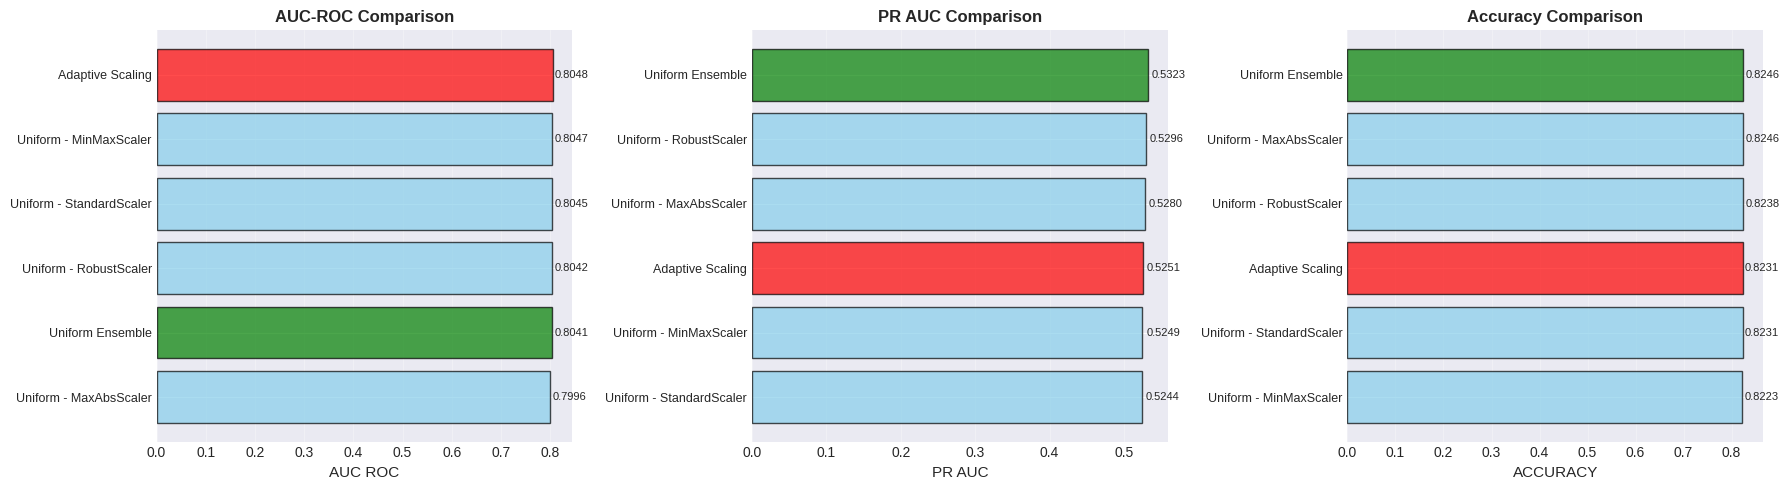


✓ Performance comparison saved to ../results/adaptive_scaling/figures/adaptive_vs_uniform_comparison.png


In [23]:
# Create performance comparison bar charts
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['auc_roc', 'pr_auc', 'accuracy']
titles = ['AUC-ROC Comparison', 'PR AUC Comparison', 'Accuracy Comparison']

for ax, metric, title in zip(axes, metrics, titles):
    # Sort by metric value
    sorted_df = comparison_df.sort_values(metric, ascending=True)
    
    # Create color map: adaptive in red, ensemble in green, uniforms in shades of blue
    colors = []
    for model in sorted_df['model']:
        if 'Adaptive' in model:
            colors.append('red')
        elif 'Ensemble' in model:
            colors.append('green')
        else:
            colors.append('skyblue')
    
    # Create horizontal bar chart
    ax.barh(range(len(sorted_df)), sorted_df[metric], color=colors, alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(sorted_df)))
    ax.set_yticklabels(sorted_df['model'], fontsize=9)
    ax.set_xlabel(metric.replace('_', ' ').upper(), fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=8)

plt.tight_layout()
save_path = FIGURES_DIR / 'adaptive_vs_uniform_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"\n✓ Performance comparison saved to {save_path}")

### 6.3 Feature-Scaler Assignment Visualization

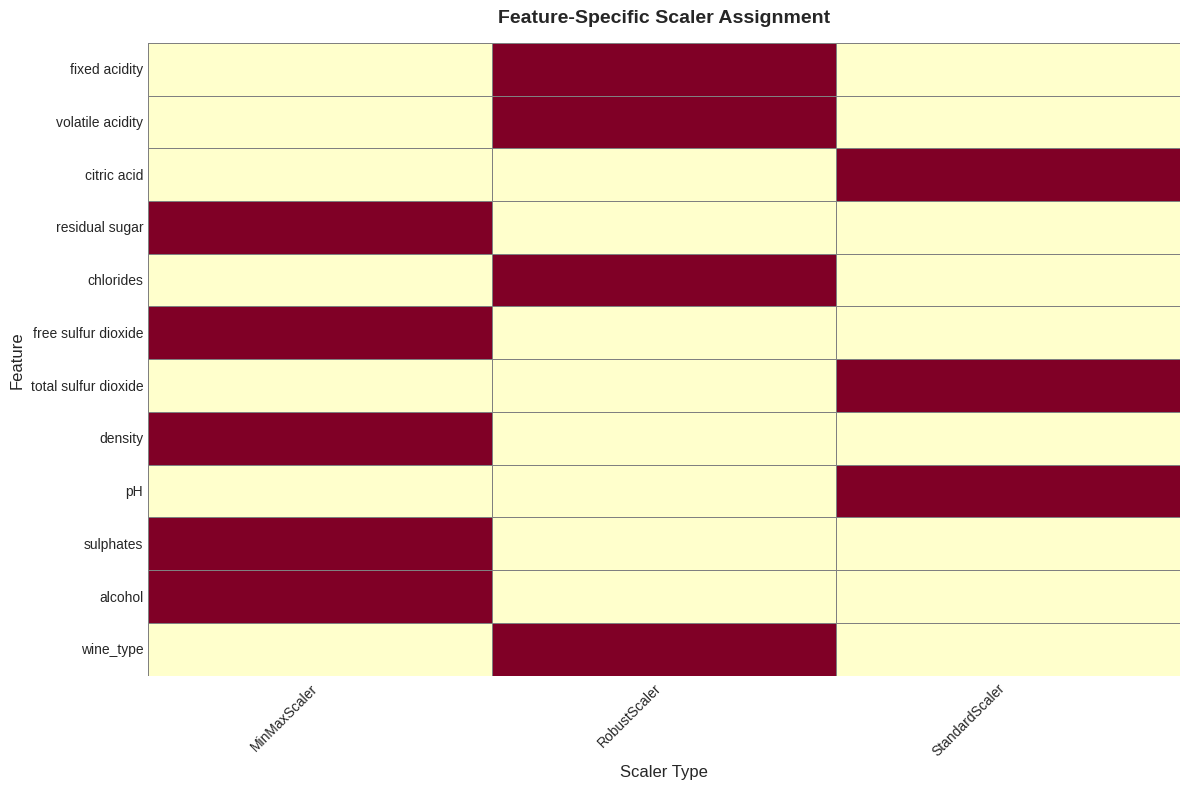

✓ Feature-scaler assignment saved to ../results/adaptive_scaling/figures/feature_scaler_assignment.png


In [24]:
# Visualize which features get which scalers
fig, ax = plt.subplots(figsize=(12, 8))

# Create a matrix for visualization
scaler_types = sorted(feature_analysis['selected_scaler'].unique())
scaler_matrix = np.zeros((len(feature_names), len(scaler_types)))

for i, feature in enumerate(feature_names):
    scaler = feature_analysis[feature_analysis['feature'] == feature]['selected_scaler'].values[0]
    j = scaler_types.index(scaler)
    scaler_matrix[i, j] = 1

# Create heatmap
sns.heatmap(scaler_matrix, 
            xticklabels=scaler_types, 
            yticklabels=feature_names,
            cmap='YlOrRd', 
            cbar=False,
            linewidths=0.5,
            linecolor='gray',
            ax=ax)

ax.set_title('Feature-Specific Scaler Assignment', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Scaler Type', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
save_path = FIGURES_DIR / 'feature_scaler_assignment.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Feature-scaler assignment saved to {save_path}")

## 7. ROC and Precision-Recall Curves

### 7.1 ROC Curves

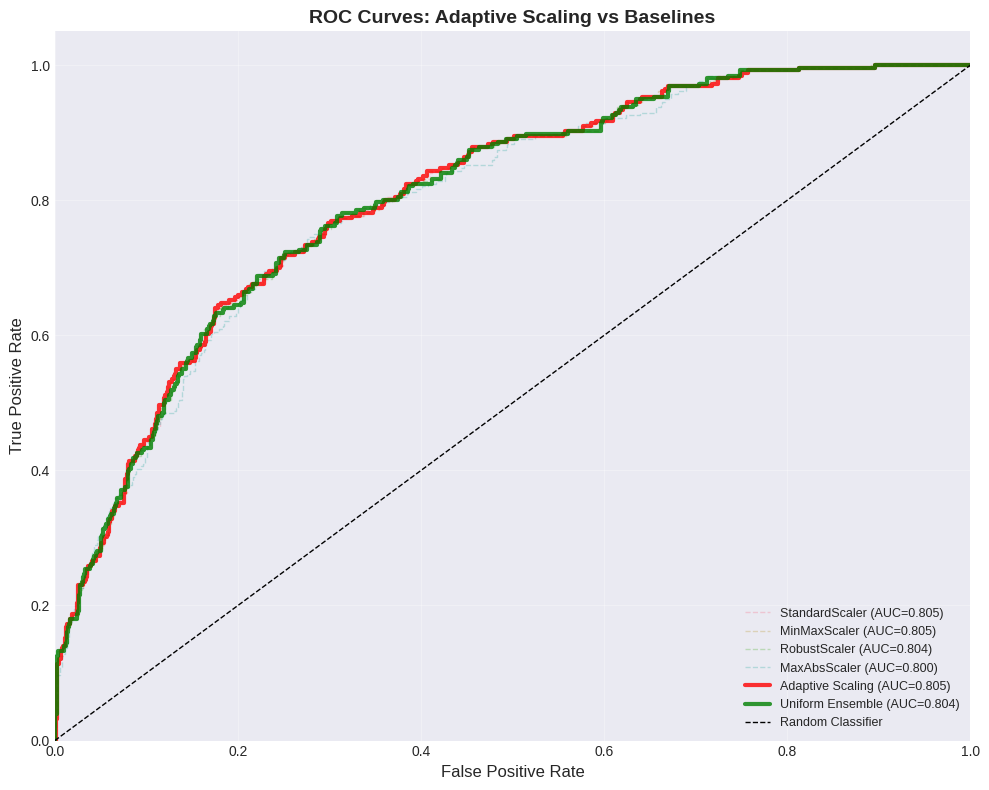

✓ ROC curves saved to ../results/adaptive_scaling/figures/roc_curves_adaptive_comparison.png


In [25]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8))

# Plot uniform scalers
for scaler_name, pipeline in uniform_models.items():
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, alpha=0.3, linestyle='--', linewidth=1,
            label=f'{scaler_name} (AUC={roc_auc:.3f})')

# Plot adaptive scaling
fpr_adaptive, tpr_adaptive, _ = roc_curve(y_test, y_pred_proba_adaptive)
roc_auc_adaptive = auc(fpr_adaptive, tpr_adaptive)
ax.plot(fpr_adaptive, tpr_adaptive, 'r-', linewidth=3, alpha=0.8,
        label=f'Adaptive Scaling (AUC={roc_auc_adaptive:.3f})')

# Plot uniform ensemble
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test, y_pred_proba_ensemble)
roc_auc_ensemble = auc(fpr_ensemble, tpr_ensemble)
ax.plot(fpr_ensemble, tpr_ensemble, 'g-', linewidth=3, alpha=0.8,
        label=f'Uniform Ensemble (AUC={roc_auc_ensemble:.3f})')

# Plot diagonal
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Adaptive Scaling vs Baselines', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
save_path = FIGURES_DIR / 'roc_curves_adaptive_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ ROC curves saved to {save_path}")

### 7.2 Precision-Recall Curves

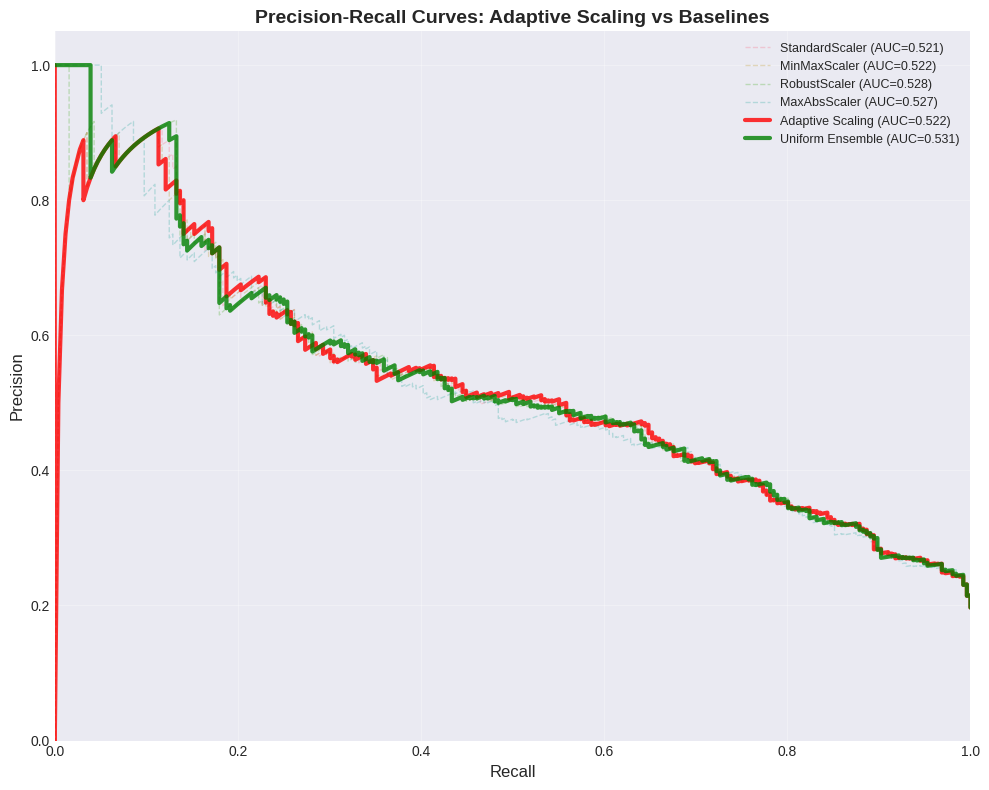

✓ Precision-Recall curves saved to ../results/adaptive_scaling/figures/pr_curves_adaptive_comparison.png


In [26]:
# Plot Precision-Recall curves
fig, ax = plt.subplots(figsize=(10, 8))

# Plot uniform scalers
for scaler_name, pipeline in uniform_models.items():
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc_val = auc(recall, precision)
    ax.plot(recall, precision, alpha=0.3, linestyle='--', linewidth=1,
            label=f'{scaler_name} (AUC={pr_auc_val:.3f})')

# Plot adaptive scaling
precision_adaptive, recall_adaptive, _ = precision_recall_curve(y_test, y_pred_proba_adaptive)
pr_auc_adaptive = auc(recall_adaptive, precision_adaptive)
ax.plot(recall_adaptive, precision_adaptive, 'r-', linewidth=3, alpha=0.8,
        label=f'Adaptive Scaling (AUC={pr_auc_adaptive:.3f})')

# Plot uniform ensemble
precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, y_pred_proba_ensemble)
pr_auc_ensemble = auc(recall_ensemble, precision_ensemble)
ax.plot(recall_ensemble, precision_ensemble, 'g-', linewidth=3, alpha=0.8,
        label=f'Uniform Ensemble (AUC={pr_auc_ensemble:.3f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curves: Adaptive Scaling vs Baselines', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
save_path = FIGURES_DIR / 'pr_curves_adaptive_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Precision-Recall curves saved to {save_path}")

## 8. Save Results

In [27]:
# Save performance comparison
comparison_path = RESULTS_DIR / 'adaptive_performance_comparison.csv'
comparison_df.to_csv(comparison_path, index=False)
print(f"✓ Performance comparison saved to {comparison_path}")

# Save feature-scaler assignment
assignment_path = RESULTS_DIR / 'feature_scaler_assignment.csv'
feature_analysis.to_csv(assignment_path, index=False)
print(f"✓ Feature-scaler assignment saved to {assignment_path}")

# Save summary comparison
summary_path = RESULTS_DIR / 'adaptive_vs_baselines_summary.csv'
comparison_summary.to_csv(summary_path, index=True)
print(f"✓ Summary comparison saved to {summary_path}")

✓ Performance comparison saved to ../results/adaptive_scaling/adaptive_performance_comparison.csv
✓ Feature-scaler assignment saved to ../results/adaptive_scaling/feature_scaler_assignment.csv
✓ Summary comparison saved to ../results/adaptive_scaling/adaptive_vs_baselines_summary.csv
